## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict

### 1. Reading dataset and initial pre-processing

In [2]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [3]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

print(len(original_data))
print(len(train_data))

24000
23998


In [4]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

6000


In [5]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [6]:
train_data['title']

0                             “Horrible experience”
1                                       “Stay Away”
2                      “Great location and service”
3                “I will never go back here again!”
4        “Ripped off our VISA card after departure”
                            ...                    
23993            “pleasant stay with good location”
23994     “Hit or miss, some things need attention”
23995                              “Good breakfast”
23996                    “Deserves a higher rating”
23997                        “Clean & comfortable!”
Name: title, Length: 23998, dtype: object

In [7]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [8]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)
 
train_data['clean_text'][0]

'First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY We thought by paying more we would get a good deal well this hotel is not the case 400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service Great time in San Diego but a nightmare of a hotel Dont ever write reviews but this one was called for if you can avoid this hotel do it Being a military family and moving from state to state we know

### 2. Exploratory Data Analysis (EDA)

In [9]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [10]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience,First of all we got there and they didnt have ...
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away,Found Racist graffiti in the room Request to c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...


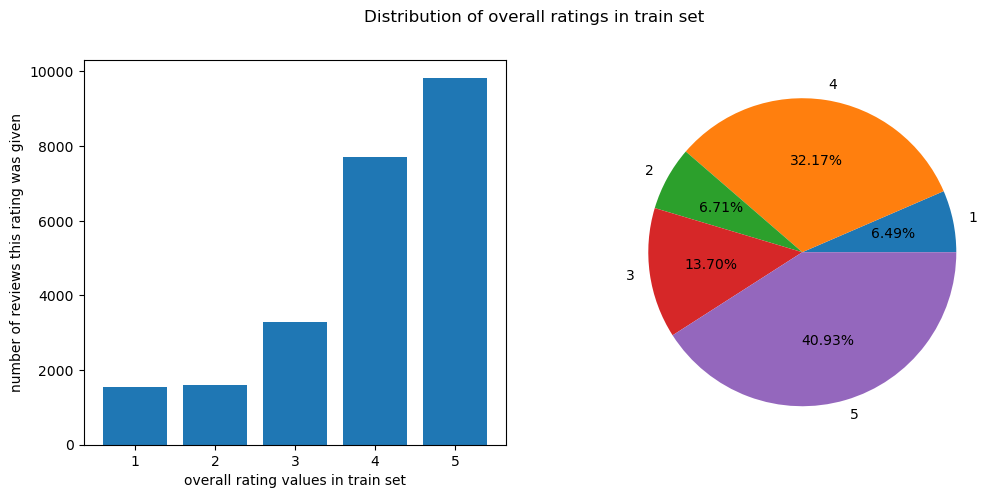

In [93]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))

    ratings_freq = Counter(ratings_distribution)
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

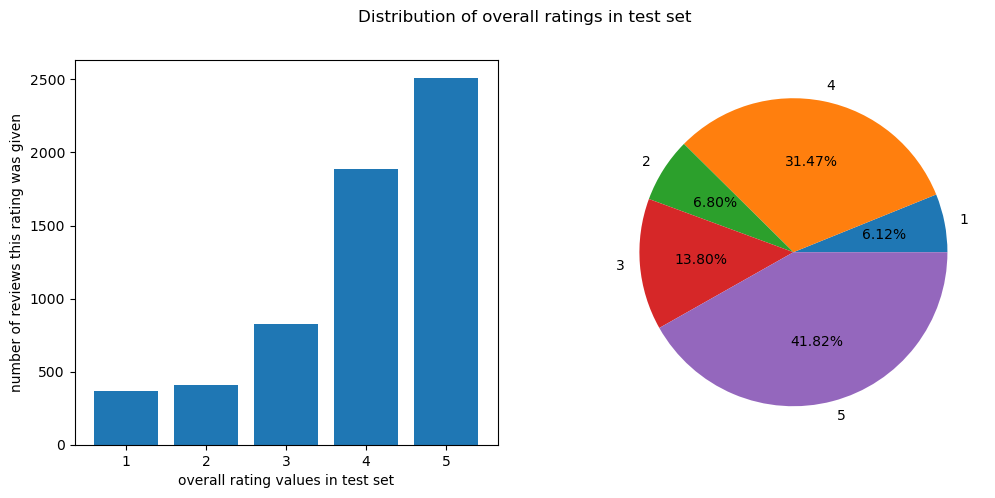

In [94]:
overall_ratings_plot(test_data, 'test')

In [50]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 62493
most frequent words use in reviews: [('the', 192545), ('and', 127800), ('a', 103768), ('to', 93843), ('was', 80158), ('I', 59749), ('in', 57570), ('of', 50150), ('The', 47904), ('is', 46002)]


In [47]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 62488


[('the', 192545),
 ('and', 127800),
 ('a', 103768),
 ('to', 93843),
 ('was', 80158),
 ('I', 59749),
 ('in', 57570),
 ('of', 50150),
 ('The', 47904),
 ('is', 46002)]

In [46]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

most_frequent_actual_words = []

for n in most_freq:
    if n[0].lower() not in stop_words:
        most_frequent_actual_words.append(n)
    if len(most_frequent_actual_words) == 10:
        break

print(most_frequent_actual_words)


[('hotel', 39292), ('room', 34699), ('stay', 16071), ('great', 14181), ('staff', 13928), ('would', 12190), ('rooms', 11191), ('nice', 10594), ('good', 10362), ('location', 10168)]


Text(0.5, 1.0, 'Most frequent words across all reviews')

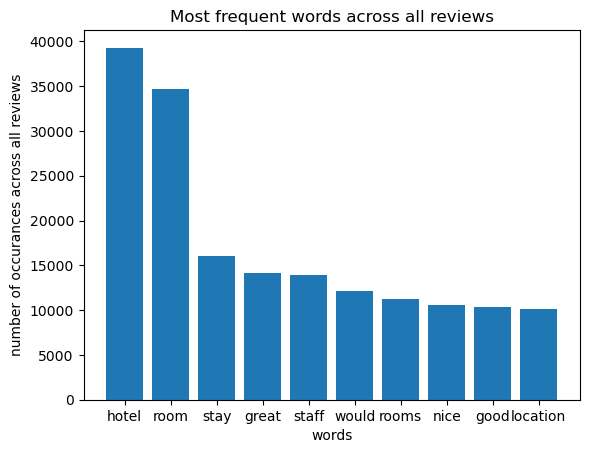

In [53]:
words, counts = zip(*most_frequent_actual_words)
plt.bar(words, counts)
plt.xlabel(f'words')
plt.ylabel('number of occurances across all reviews')
plt.title(f'Most frequent words across all reviews')

### 3. Selection and training Machine Learning models

### 4. Experiment with VADER sentiment lexicon

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix